Terry Boo Chee Yee, Li Sheng | P2211194, P2309110 | DAAA/FT/2B/22 | Deep Learning CA2 - Part A (GAN)

<h1><Center>Generative Adverserial Network</Center></h1>

# Progression (Delete after finish with part A)

## Done

- Check for unique classes in the dataset
- Plotted sample images with it's label
- Plotted number of image in each class
- Check if there are images with contsant pixel values (image that appears completely uniform or monochromatic, lacking any discernible features, textures, or details)
- Class where the constant pixel images belong to
- Check for duplicated images
- Cleaned the dataset by removing the '-1' and use a bar graph to show the number of images in each class
###### Preprocessing
- Getting original, normalized and binarized versions of the images
- Data augmentation
- ?

## To do

- Duplicated images (Pixel Values are the same)
- Deal with black images in class '-1' (Done: Decided to drop them)
- Deal with contant pixel images
- Deal with mislabeled images

# Overview

# Table of contents

- [1. Background](#1)
- [2. Set Up](#2)
  - [2.1 Importing Libraries](#2.1)
  - [2.2 Loading the Dataset](#2.2)
- [3. Exploratory Data Analysis](#3)
  - [3.1 Shape of the Data](#3.1)
  - [3.2 Unique Classes in the Dataset](#3.1)
  - [3.3 Sample Images From Each Class](#3.2)
  - [3.4 Number of Images in Each Class](#3.4)
- [4. Data Cleaning](#4)
  - [4. Excluding Irrelevant Images](#4)
- [3. Data Preprocessing](#5)

# Background <a id = '1'></a>

__Task__

We are working on a project to create 260 small black-and-white images

__What are GANs__

Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

__Main components of GAN__

- Discriminator

The discriminator in a GAN is simply a classifier. It tries to distinguish real data from the data created by the generator. It could use any network architecture appropriate to the type of data it's classifying.

- Generator

The generator part of a GAN learns to create fake data by incorporating feedback from the discriminator. It learns to make the discriminator classify its output as real.

__How Gan works__

First, the generator creates samples from random noise inputs and feeds these generated samples into the discriminator. The discriminator then tries to classify whether each sample is real (from the actual data distribution) or generated (fake).

__If you are asked to generate images of a specific class, propose a way of doing it__

__If you are asked to generate coloured images instead of black-and-white ones, do you think it would be easier or harder to produce better quality results__

__What class(es) is/are relatively easier/harder to generate? Why?__

__References__

https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/

https://developers.google.com/machine-learning/gan/gan_structure

# Set Up <a id = '2'></a>

## Importing Libraries <a id = '2.1'></a>

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import random
import os
import shutil
import tensorflow as tf
import math
from PIL import Image
from collections import Counter

# Visualizations Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Utility  Libraries
from sklearn.utils import resample
from tensorflow.keras.utils import Sequence
import tensorflow.keras.utils as image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory

# Pre-Processing Libraries
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

# Model Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

#Layers Libraries
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

#Callback Libraries
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Evaluation Libraries
from sklearn.metrics import classification_report
from visualkeras import layered_view
from sklearn.metrics import confusion_matrix

# ignore warnings
import pickle
import warnings
warnings.filterwarnings("ignore")

## Loading the Dataset <a id = '2.2'></a>

In [2]:
# Load the CSV file into a DataFrame
df = pd.read_csv('emnist-letters-train.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Exploratory Data Analysis <a id = '3'></a>

## Shape of the Data <a id = '3.1'></a>

In [3]:
# Convert DataFrame to NumPy array
data = df.values
# Check the shape of the data
print("Shape of data array:", data.shape)

Shape of data array: (99040, 785)


## Unique pixel values in the dataset

In [4]:
# Extract pixel values (assuming they start from column index 1)
pixel_values = df.iloc[:, 1:].values.flatten()

# Get unique pixel values
unique_pixel_values = np.unique(pixel_values)

print("Unique Pixel Values:")
print(unique_pixel_values)

Unique Pixel Values:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 2

## Check if there are images with contsant pixel values

In [5]:
def is_constant_image(row):
    pixel_values = row.iloc[1:].values 
    # If the rest of the pixel values is the same as the first pixel value
    return np.all(pixel_values == pixel_values[0])

In [6]:
# Apply the function to each row and filter for constant pixel value rows
constant_images = df[df.apply(is_constant_image, axis=1)]

print(f"Number of constant pixel value images: {constant_images.shape[0]}")


# Retrieve unique class labels for constant pixel value images
unique_constant_pixel_class = np.unique(constant_images.iloc[:, 0].values)


print(f'Class labels for images with constant pixel values: {unique_constant_pixel_class}')

Number of constant pixel value images: 10240
Class labels for images with constant pixel values: [-1]


## Check for duplicated images

In [7]:
# Check for duplicated rows based on pixel values
duplicated_rows = df.duplicated(subset=df.columns[1:], keep=False)

# Filter the DataFrame to show duplicated rows
duplicated_images = df[duplicated_rows]

# Group the duplicated images together based on pixel values
grouped_duplicates = duplicated_images.groupby(list(df.columns[1:]), as_index=False).apply(lambda x: x.reset_index(drop=True))

grouped_duplicates

0    1    2    3    4    5    6    7    8    9    ...  775  776  777  \
0   0    -1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
    1    -1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
    2    -1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
    3    -1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
    4    -1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
257 35   -1  255  255  255  255  255  255  255  255  255  ...  255  255  255   
    36   -1  255  255  255  255  255  255  255  255  255  ...  255  255  255   
    37   -1  255  255  255  255  255  255  255  255  255  ...  255  255  255   
    38   -1  255  255  255  255  255  255  255  255  255  ...  255  255  255   
    39   -1  255  255  255  255  255  255  255  255  255  ...  255  255  255   

        778  779  780  781  782  783  784  
0   0     0    0    0    0    0    0    0  
    1     0    0    0    0    0    0    0  
    2     0    0    0    0    0    0    0  
    3     0    0    0    0    0    0    0  
    4     0    0    0    0    0    0    0  
...     ...  ...  ...  ...  ...  ...  ...  
257 35  255  255  255  255  255  255  255  
    36  255  255  255  255  255  255  255  
    37  255  255  255  255  255  255  255  
    38  255  255  255  255  255  255  255  
    39  255  255  255  255  255  255  255  

[10244 rows x 785 columns]

## Unique Classes in the Dataset

In [8]:
# Extract the first column
classes = data[:, 0]

# Get unique classes
unique_classes = np.unique(classes)

# Print the unique classes array
print("Unique classes array:")
print(unique_classes)

Unique classes array:
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]


## Sample Images From Each Class <a id = '3.2'></a>

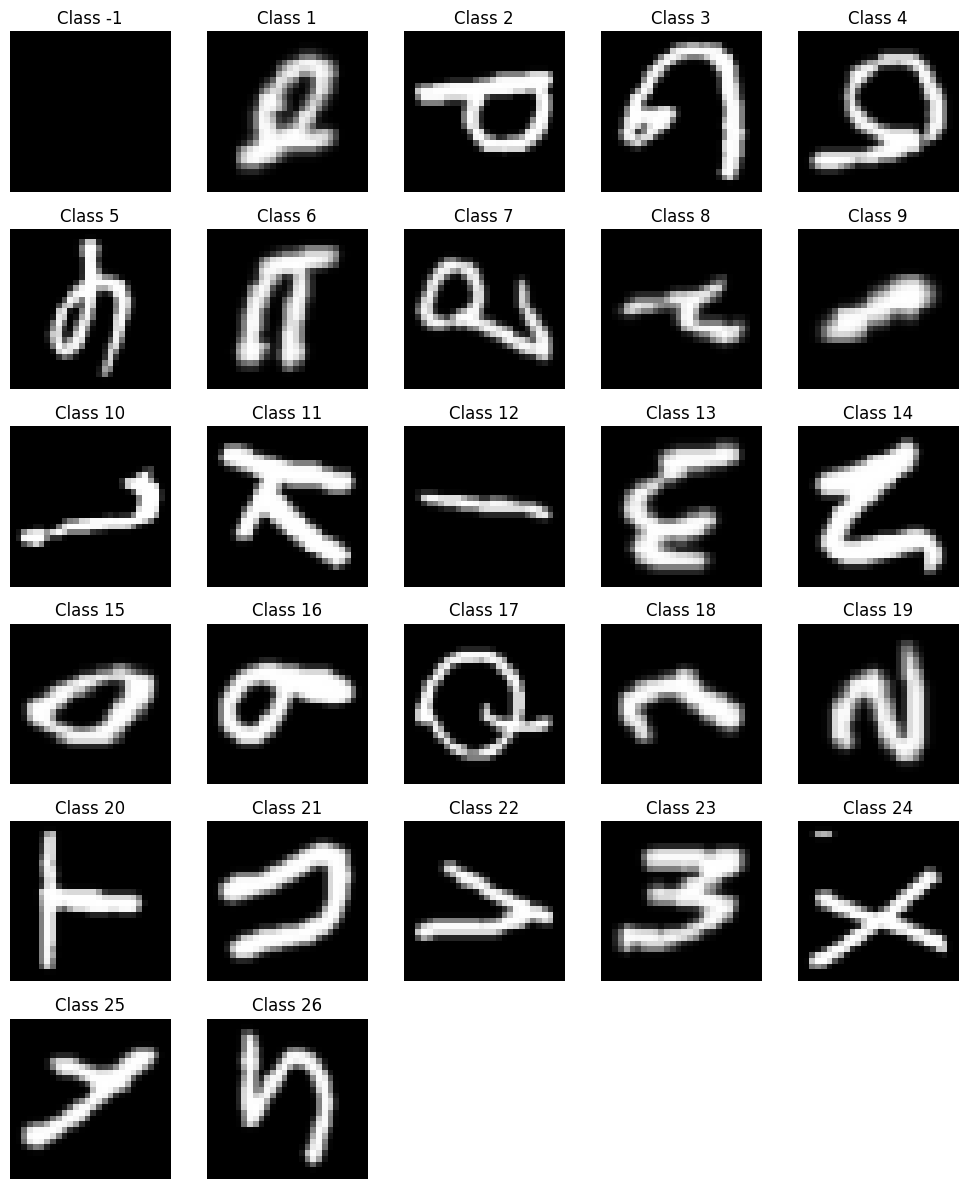

In [9]:
image_size = 28
classes = data[:, 0]

# Reshape pixel data into images
num_images = data[:, 1:].shape[0]
images = data[:, 1:].reshape(num_images, image_size, image_size).astype(np.uint8)

# Get unique classes
unique_classes = np.unique(classes)

def plot_random_images_per_class(images, classes, num_images_per_row=5):
    num_classes = len(unique_classes)
    num_rows = int(np.ceil(num_classes / num_images_per_row))
    
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(num_images_per_row * 2, num_rows * 2))
    
    for i, cls in enumerate(unique_classes):
        class_indices = np.where(classes == cls)[0]
        random_index = np.random.choice(class_indices)
        row = i // num_images_per_row
        col = i % num_images_per_row
        axes[row, col].imshow(images[random_index], cmap='gray')
        axes[row, col].set_title(f'Class {cls}')
        axes[row, col].axis('off')
    
    # Hide any extra subplots if num_classes is not a multiple of num_images_per_row
    for j in range(num_classes, num_rows * num_images_per_row):
        axes.flatten()[j].axis('off')
    
    plt.tight_layout()

# Display one random image from each class in rows of 5
plot_random_images_per_class(images, classes, num_images_per_row=5)
plt.show()

## Number of Images in Each Class

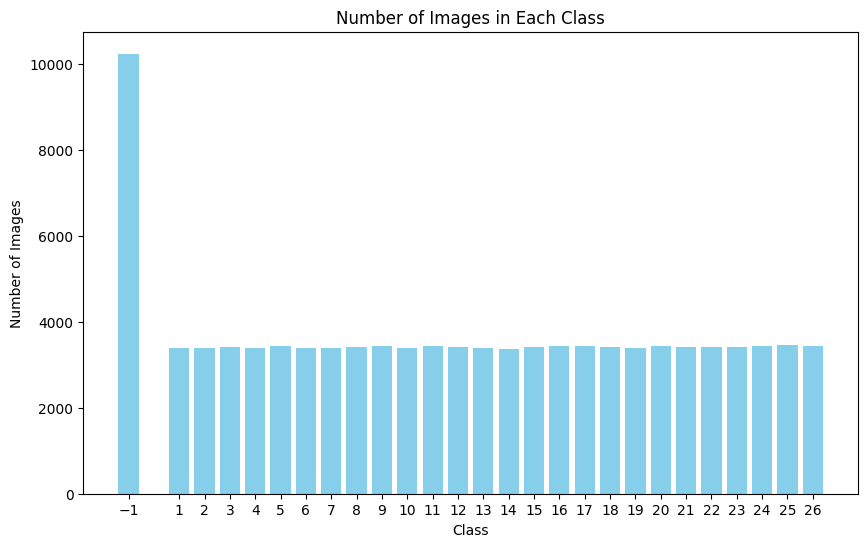

In [10]:
classes = data[:, 0]

# Get unique classes and count occurrences
unique_classes, counts = np.unique(classes, return_counts=True)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(unique_classes)
plt.show()

## Further Investigating the '-1' Class

### Display rows with class '-1'

In [11]:
minus_one_class_df = pd.DataFrame(data[data[:, 0] == -1])
minus_one_class_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,-1,89,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,89,89,89
1,-1,216,216,216,216,216,216,216,216,216,...,216,216,216,216,216,216,216,216,216,216
2,-1,74,74,74,74,74,74,74,74,74,...,74,74,74,74,74,74,74,74,74,74
3,-1,148,148,148,148,148,148,148,148,148,...,148,148,148,148,148,148,148,148,148,148
4,-1,103,103,103,103,103,103,103,103,103,...,103,103,103,103,103,103,103,103,103,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,-1,205,205,205,205,205,205,205,205,205,...,205,205,205,205,205,205,205,205,205,205
10236,-1,153,153,153,153,153,153,153,153,153,...,153,153,153,153,153,153,153,153,153,153
10237,-1,132,132,132,132,132,132,132,132,132,...,132,132,132,132,132,132,132,132,132,132
10238,-1,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174


### Rows with pixel values constant

In [12]:
print(f"Number of constant pixel value images: {minus_one_class_df[minus_one_class_df.apply(is_constant_image, axis=1)].shape[0]}")

Number of constant pixel value images: 10240


# Data Cleaning <a id = '4'></a>

In [43]:
cleaned_df = df.copy()

## Excluding Images with Constant Pixel Values

In [44]:
# Filtering
cleaned_df = cleaned_df[cleaned_df.iloc[:, 0] != -1]

# Print the number of images after removing blank images
print(f'Number of images after removing blank images: {cleaned_df.shape[0]}')
cleaned_df

Number of images after removing blank images: 88800


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99032,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99033,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99035,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99036,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Unique Classes in the Dataset after cleaning

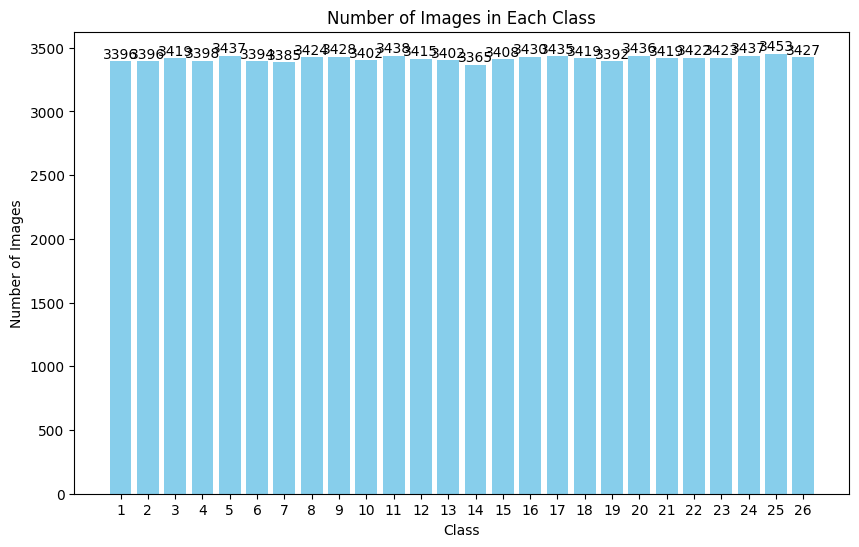

In [46]:
# Extract the class labels
classes = cleaned_df.iloc[:, 0]

# Get unique classes and count occurrences
unique_classes, counts = np.unique(classes, return_counts=True)

# Plotting the graph
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_classes, counts, color='skyblue')

# Adding text on top of each bar
for bar, count in zip(bars, counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, int(count), ha='center', va='bottom')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(unique_classes)
plt.show()

# Data Preprocessing <a id = '5'></a>

## Original | Normalized | Binarized <a id = '3.1'></a>

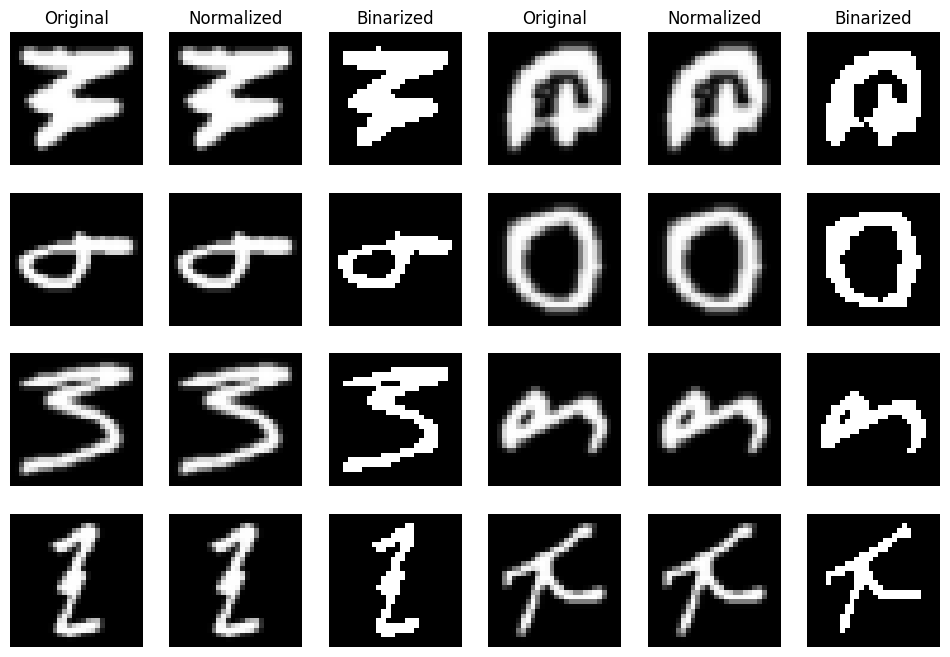

In [47]:
# Convert DataFrame to NumPy array
data = cleaned_df.values

# Assuming each image is 28x28 pixels and the remaining columns are pixel values
image_size = 28
num_images = data.shape[0]

# Extract pixel data and reshape each row into a 28x28 array
original_images = data[:, 1:].reshape(num_images, image_size, image_size).astype(np.uint8)

# Normalize pixel values
normalized_images = original_images / 255.0

# Binarize the images by applying a threshold
threshold = 0.5
binarized_images = (normalized_images > threshold).astype(np.uint8)

# Define a function to display multiple images before and after processing
def plot_images(original_images, normalized_images, binarized_images, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols*3, figsize=(ncols*6, nrows*2))
    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            if index < len(original_images):
                # Display original image
                ax_original = axes[i, j*3]
                ax_original.imshow(original_images[index], cmap='gray')
                ax_original.axis('off')
                if i == 0:
                    ax_original.set_title('Original')
                
                # Display normalized image
                ax_normalized = axes[i, j*3 + 1]
                ax_normalized.imshow(normalized_images[index], cmap='gray')
                ax_normalized.axis('off')
                if i == 0:
                    ax_normalized.set_title('Normalized')
                
                # Display binarized image
                ax_binarized = axes[i, j*3 + 2]
                ax_binarized.imshow(binarized_images[index], cmap='gray')
                ax_binarized.axis('off')
                if i == 0:
                    ax_binarized.set_title('Binarized')

# Display the first 10 images before and after processing
num_display = 8
plot_images(original_images[:num_display], normalized_images[:num_display], binarized_images[:num_display], nrows=4, ncols=2)
plt.show()

## Data Augmentation ??????? <a id = '3.1'></a>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Example assuming binarized_images is a DataFrame with labels in the first column and images in subsequent columns
# Accessing images and labels from the DataFrame
binarized_images = cleaned_df.values  # Assuming cleaned_df is your DataFrame

# Separate images by class
class_images = {}
for row in binarized_images:
    label = row[0]
    img = row[1:]  # Assuming the rest are image data
    if label not in class_images:
        class_images[label] = []
    class_images[label].append(img)

# Define the target number of samples per class
target_samples = 3500

# Set up data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

augmented_images = []
augmented_labels = []

# Function to preprocess and augment images
def preprocess_and_augment(img):
    img = img.reshape((1, 28, 28, 1))  # Reshape for ImageDataGenerator
    augmented_iter = datagen.flow(img, batch_size=1)
    augmented_img = next(augmented_iter)[0].reshape((28, 28, 1))
    return augmented_img

# Iterate over each class
for label, images in class_images.items():
    while len(images) < target_samples:
        for img in images[:target_samples - len(images)]:  # Limit to remaining required samples
            augmented_img = preprocess_and_augment(img)
            augmented_images.append(augmented_img)
            augmented_labels.append(label)

# Convert to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Shuffle the dataset
shuffle_indices = np.random.permutation(len(augmented_images))
augmented_images = augmented_images[shuffle_indices]
augmented_labels = augmented_labels[shuffle_indices]

print(f'Total number of images after augmentation: {len(augmented_images)}')


## Contrast adjustment and smoothing <a id = '3.1'></a>

In [77]:
import cv2

def preprocess_image(img):
    # Contrast adjustment
    img = cv2.convertScaleAbs(img, alpha=1.5, beta=0)
    # Gaussian smoothing
    img = cv2.GaussianBlur(img, (3, 3), 0)
    return img

preprocessed_images = np.array([preprocess_image(img) for img in binarized_images])

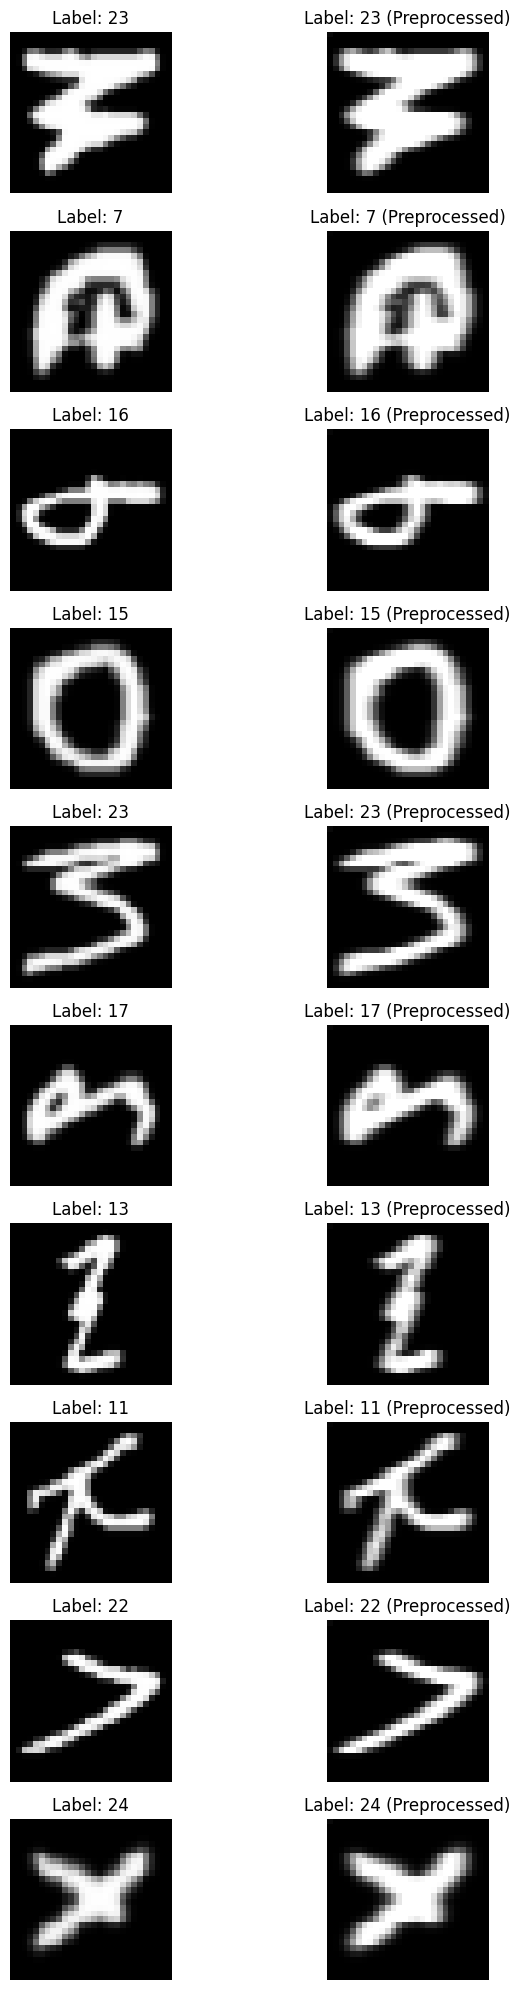

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming binarized_images and preprocess_image function are defined as mentioned
# binarized_images is assumed to have the label as the first column

# Display the first 10 images before and after preprocessing
fig, axes = plt.subplots(10, 2, figsize=(8, 20))

for i in range(10):
    # Before preprocessing
    img_before = binarized_images[i, 1:].reshape(28, 28)  # Assuming pixel values start from index 1
    label = binarized_images[i, 0]  # Label is in the first column
    axes[i, 0].imshow(img_before, cmap='gray')
    axes[i, 0].set_title(f'Label: {label}')
    axes[i, 0].axis('off')
    
    # After preprocessing
    img_after = preprocessed_images[i, 1:].reshape(28, 28)  # Exclude the label and reshape to 28x28
    axes[i, 1].imshow(img_after, cmap='gray')
    axes[i, 1].set_title(f'Label: {label} (Preprocessed)')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


Terry was here